In [16]:
# change working directory
import os
os.chdir('/athena/marchionnilab/scratch/lab_data/Mohamed/pca_outcome')

In [17]:
#os.environ["CUDA_VISIBLE_DEVICES"]='0,1'

In [18]:
import pandas as pd
import re
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import matplotlib
import hdbscan
import itertools
import matplotlib.patches as patches
import torch
import os

In [11]:
# from GPUtil import showUtilization as gpu_usage
# from numba import cuda

# def free_gpu_cache():
#     print("Initial GPU Usage")
#     gpu_usage()                             

#     torch.cuda.empty_cache()

#     cuda.select_device(0)
#     cuda.close()
#     cuda.select_device(0)

#     print("GPU Usage after emptying the cache")
#     gpu_usage()

# free_gpu_cache()   

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  1% |
|  1 |  0% |  0% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  6% |  1% |
|  1 |  0% |  0% |


In [28]:
os.environ["CUDA_VISIBLE_DEVICES"]=""

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [30]:
df = torch.load('/athena/marchionnilab/scratch/lab_data/Mohamed/pca_outcome/objs/karen/model_pten/pten_10x_att_A32_patch200/patchpredictionloss.pkl', map_location=device)
# embed_list = df['embed_list']
# embed_data = []
# for embed in embed_list:
#     embed_data += embed[:5]
        
# for i in range(len(embed_data)):
#     embed_data[i] = embed_data[i].flatten()
    
# embed_data = np.array(embed_data)    
# #slide ground truth
# label_data = []
# label_list = df['y_true']
# for label in label_list: 
#     label_data += [int(label)]*5
# #slide prediction
# slide_pred_data = []
# slide_pred_list = df['y_pred']
# for slide_pred in slide_pred_list: 
#     slide_pred_data += [slide_pred]*5
# #patch prediction
# pred_list = df['patch_pred']
# pred_data = []
# for pred in pred_list:
#     pred_data += pred[:5]
# pred_data = np.array(pred_data)  

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [25]:
patch_path = list(df['patch_name'])
patch_paths = []
for i in range(len(patch_path)):
    patch_paths.append(list(itertools.chain(*patch_path[i][:5])))
patch_paths = list(itertools.chain(*patch_paths))

In [15]:
# get umap embed
reducer = umap.UMAP(
    n_neighbors=10,
    min_dist=0.0,
    n_components=3) #n_components=2, n_neighbors=40, min_dist=0.4
embed_data = StandardScaler().fit_transform(embed_data)
embedding = reducer.fit_transform(embed_data)

(0.6876615285873413, 8.840415954589844, 9.406227111816406, 2.2230920791625977)

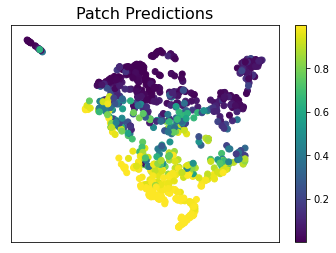

In [16]:
#plot
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=pred_data)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('Patch Predictions', fontsize=16)
plt.axis([min(embedding[:, 0])-0.5,max(embedding[:, 0])+0.5, max(embedding[:, 1])+0.5,min(embedding[:, 1])-0.5])

In [17]:
#kmeans
import sklearn.cluster as cluster
clusteredlabels = cluster.KMeans(n_clusters=11).fit_predict(embedding)

In [128]:
#cluster
#clusteredlabels = hdbscan.HDBSCAN(
#    min_samples=1,
#    min_cluster_size=10,
#).fit_predict(embedding)

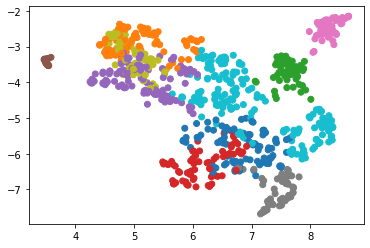

In [136]:
#clustered = (clusteredlabels >= 0)
#plt.scatter(embedding[~clustered, 0],
#            -embedding[~clustered, 1],
#            color=(0.5, 0.5, 0.5))
#plt.scatter(embedding[clustered, 0],
#            -embedding[clustered, 1],
#            c=clusteredlabels[clustered],
#            cmap='tab20c');
plt.scatter(embedding[:,0],
            -embedding[:,1],
            c=clusteredlabels,
            cmap='tab10');

In [7]:
import random
import json
import matplotlib.pyplot as plt
import pickle
from PIL import Image, ImageOps
import matplotlib.cm as cm

In [26]:
imageroot = '/Volumes/1.45TB/Glioma/umap/umappatches'
patch_paths = [imageroot+pp[46:] for pp in patch_paths]

In [22]:
tx, ty = embedding[:,0], embedding[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

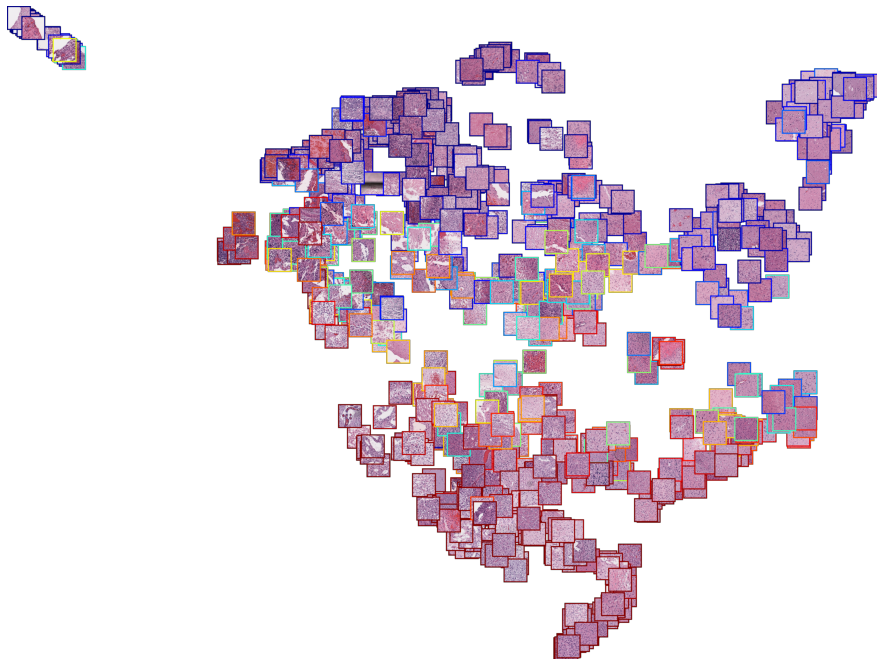

In [35]:
width = 4000
height = 3000
max_dim = 100
cmap = cm.get_cmap('jet')
full_image = Image.new('RGBA', (width, height))
for img, x, y,c in zip(patch_paths, tx, ty,pred_data):
    
    color= matplotlib.colors.rgb2hex(cmap(c))
        
    tile = Image.fromarray(np.load(img))
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    tile_pred = ImageOps.expand(tile,border=5, fill=color)
    full_image.paste(tile_pred, (int((width-max_dim)*x), int((height-max_dim)*y)), 
                     mask=tile_pred.convert('RGBA'))
    

plt.figure(figsize = (16,12))
plt.axis('off')
plt.imshow(full_image)
plt.savefig('umap_confident_patch.png',dpi=600)

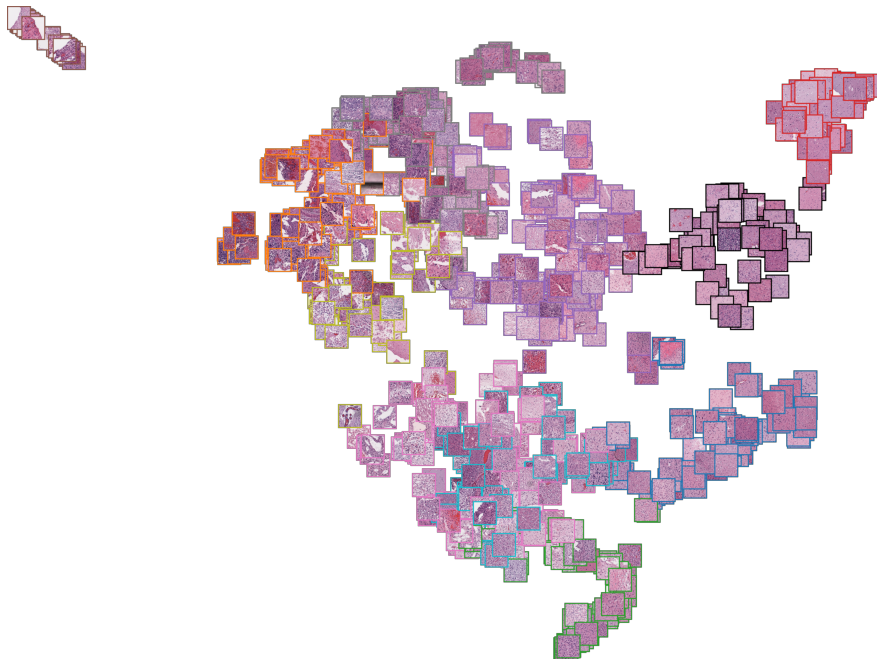

In [28]:
width = 4000
height = 3000
max_dim = 100
#cmap = cm.get_cmap('tab10', np.max(clusteredlabels))
cmap = cm.get_cmap('tab10', 10)
full_image = Image.new('RGBA', (width, height))
for img, x, y,c in zip(patch_paths, tx, ty,clusteredlabels):
    if c==10:
        color = 'black'
    else: 
        color= matplotlib.colors.rgb2hex(cmap(c))
        
    tile = Image.fromarray(np.load(img))
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    tile_cluster = ImageOps.expand(tile,border=5, fill=color)
    full_image.paste(tile_cluster, (int((width-max_dim)*x), int((height-max_dim)*y)), 
                     mask=tile_cluster.convert('RGBA'))
    

plt.figure(figsize = (16,12))
plt.axis('off')
plt.imshow(full_image)
plt.savefig('umap_confident_patch_clusters.png',dpi=600)

In [36]:
#patch_paths, clusteredlabels
color=[]
cmap = cm.get_cmap('tab10', np.max(clusteredlabels))
for c in clusteredlabels:
    if c==10:
        color.append('black')
    else: 
        color.append(matplotlib.colors.rgb2hex(cmap(c))) 
df_=pd.DataFrame({'patch_paths':patch_paths,'clusteredlabels':clusteredlabels,'color':color}).groupby('clusteredlabels').apply(lambda x: x.sample(5)).reset_index(drop=True)

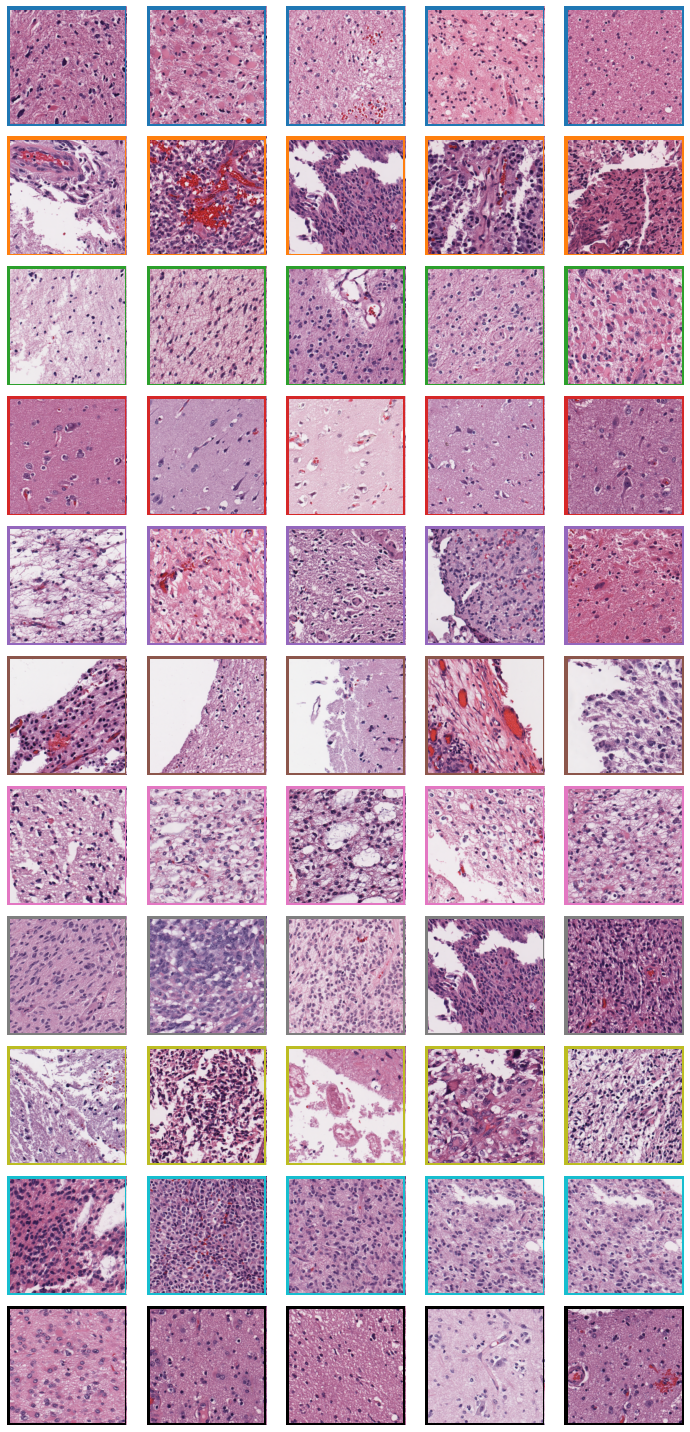

In [39]:
fig = plt.figure(figsize=(10,20))

for r in range(11):
    for c in range(5):
        index = 5*r+c+1
        fig.add_subplot(11,5,index)
        plt.axis('off')
        tile = np.load(df_.patch_paths[index-1])
        plt.imshow(tile)
        rect = patches.Rectangle((0,0), 256, 256, linewidth=5, edgecolor=df_.color[index-1], facecolor='none')
        ax = plt.gca()
        ax.add_patch(rect)
        
fig.tight_layout()
plt.savefig('umap_patch_clusters_kmeans.png',dpi=600)